# 2023-05-04 东吴证券-优加换手率 UTR 选股因子 2.0

In [1]:
import pandas as pd
import datetime
from tqdm import tqdm
import numpy as np
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

df_turn = pd.read_csv(r'C:\Users\nibh\Desktop\FZ\daily_factor\EODDI__S_DQ_TURN.csv',index_col=0)
df_turn = df_turn[df_turn.index>='2017-01-01']
df_turn.index = pd.to_datetime(df_turn.index).date
df_mv = pd.read_csv(r'C:\Users\nibh\Desktop\FZ\daily_factor\EODDI__S_DQ_MV.csv',index_col=0)
df_mv = df_mv[df_mv.index>='2017-01-01']
df_mv.index = pd.to_datetime(df_mv.index).date

In [89]:

df_turn_mean = df_turn.rolling(20,min_periods=10).mean()
df_turn_std = df_turn.rolling(20,min_periods=10).std()
df_mv_pct = df_mv.div(df_mv.sum(axis=1),axis=0)

# 截断离群值
def rm_outlier(df):
    for i in tqdm(df.index):
        q3 = df.loc[i].quantile(0.75)
        q1 = df.loc[i].quantile(0.25)
        iqr = q3 - q1
        high_bench = q3 + 1.5*iqr
        low_bench = q1 - 1.5*iqr
        df.loc[i] = np.clip(df.loc[i],low_bench,high_bench)
    return df

df_turn_mean_clean = rm_outlier(df_turn_mean).iloc[9:,]
df_turn_std_clean = rm_outlier(df_turn_std).iloc[9:,]
df_mv_pct = df_mv_pct.iloc[9:,]

# 市值中性化
def market_neutralization(df_x,df_y):
    df_residual = pd.DataFrame(index=df_x.index,columns=df_x.columns)
    for date in tqdm(df_x.index):
        x = df_x.loc[date,].dropna()
        y = df_y.loc[date,].dropna()
        df_input = pd.concat([x,y],axis=1,join='inner')
        model = LinearRegression()
        model.fit(X=pd.DataFrame(df_input.iloc[:,0]),y=pd.DataFrame(df_input.iloc[:,1]))
        yhat = model.predict(pd.DataFrame(df_input.iloc[:,0]))
        residual = df_input.iloc[:,1] - yhat.flatten()
        df_residual.loc[date,] = residual
    return df_residual


# 量小换手率因子TURN20 及 量稳换手率因子STR
factor_turn20 = market_neutralization(df_mv_pct,df_turn_mean_clean)
factor_str = market_neutralization(df_mv_pct,df_turn_std_clean)


# 优加法结合量小和量稳（次序尺度）--优加换手率因子UTR
'''
1.先按量稳因子从小到大排序，打分1,2,……,N-1,N,N,记为“得分 1”；
2.对于量稳因子排名靠前的50%样本，再将按量小因子从大到小排序，
打分1,2,……,N/2,记为“得分 2”；“得分 1”+“得分 2”，即为这些股票的最终得分；
3.对于量稳因子排名靠后的50%样本，则按量小因子从小到大排序，
打分 1,2,……,N/2，记为“得分 3”；这些股票的最终得分为“得分 1”+“得分 3”
'''
score_1 = factor_str.rank(axis=1, method='min', ascending=True)
half_point = score_1.count(axis=1) // 2
score_2 = factor_turn20[score_1 <= half_point[:, np.newaxis]].rank(axis=1, method='min', ascending=False)
score_3 = factor_turn20[score_1 > half_point[:, np.newaxis]].rank(axis=1, method='min', ascending=True)
factor_utr = score_1 + score_2
factor_utr[score_1 > half_point[:, np.newaxis]] = score_1[score_1 > half_point[:, np.newaxis]] + score_3


# 优加法结合量小和量稳（激活函数softsign）--优加换手率因子UTR2.0
def softsign(x):
    return x / (1 + np.abs(x))
factor_urt2 = factor_str + softsign(factor_str) * factor_turn20


100%|██████████████████████████████████████████████████████████████████████████████| 1564/1564 [06:16<00:00,  4.16it/s]


factor_name: factor_turn20
start_date,end_date 2017-01-16 2023-06-01


100%|██████████████████████████████████████████████████████████████████████████████| 1549/1549 [00:27<00:00, 56.64it/s]


Sharpe ratio of long_ret_cumprod is:  0.445
Sharpe ratio of long2bench is:  0.263
Max drawdown of long_ret_cumprod is: -36.25%


,turnover,gross,net
group_01,0.034502,0.000228,0.000180
group_02,0.082886,0.000330,0.000214
group_03,0.116053,0.000318,0.000155
group_04,0.137169,0.000293,0.000101
group_05,0.148125,0.000206,-0.000001
group_06,0.150955,0.000183,-0.000029
group_07,0.144751,0.000130,-0.000073
group_08,0.131736,-0.000045,-0.000229
group_09,0.109013,-0.000293,-0.000446
group_10,0.074667,-0.001349,-0.001453


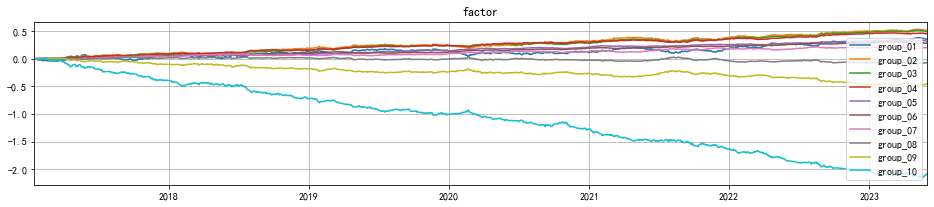

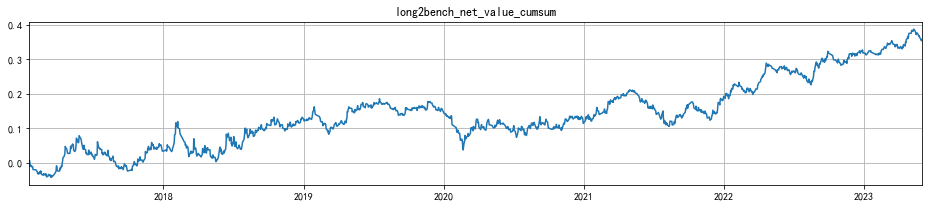

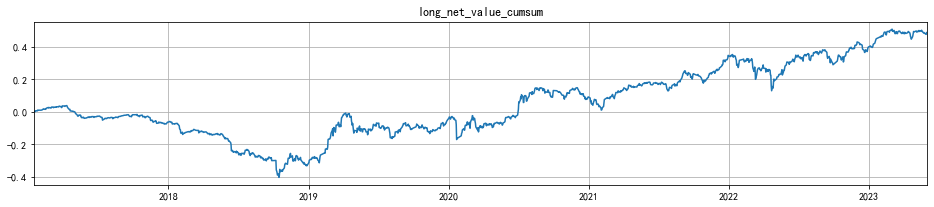

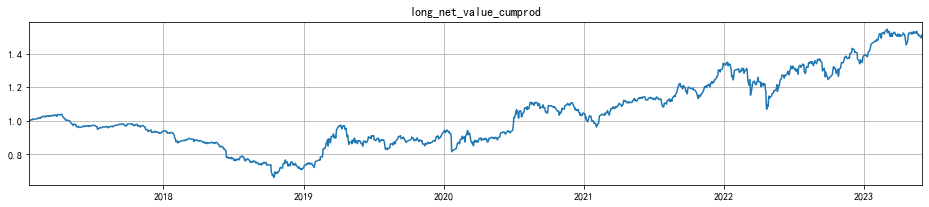

In [83]:
# 量小换手率因子
%run Quant_useful_packages.ipynb
C = SingleFactorAnalysis('000985.SH', '20170116', '20230601', 'factor_turn20', 'pct_close_next_close', long_low=1, dt_index='240m', n_group=10, neu_style=None, calc_crowd=False)
result_df = C.run_code(nextpct_shift=1)
result_df

factor_name: factor_str
start_date,end_date 2017-01-16 2023-06-01


100%|██████████████████████████████████████████████████████████████████████████████| 1549/1549 [00:28<00:00, 54.72it/s]


Sharpe ratio of long_ret_cumprod is:  0.602
Sharpe ratio of long2bench is:  0.037
Max drawdown of long_ret_cumprod is: -35.10%


,turnover,gross,net
group_01,0.065001,0.000343,0.000252
group_02,0.148767,0.000387,0.000178
group_03,0.189174,0.000452,0.000187
group_04,0.208338,0.000373,0.000081
group_05,0.213983,0.000347,0.000048
group_06,0.211065,0.000226,-0.000070
group_07,0.198928,0.000072,-0.000207
group_08,0.178875,-0.000079,-0.000329
group_09,0.145528,-0.000458,-0.000661
group_10,0.092157,-0.001663,-0.001792


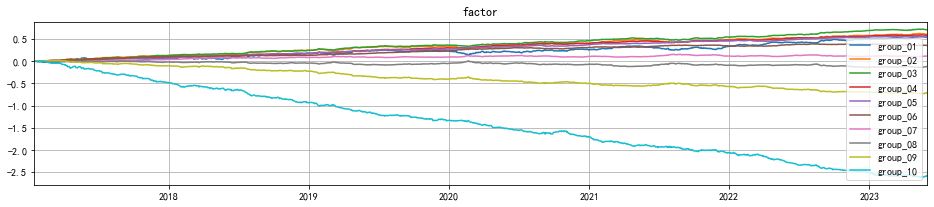

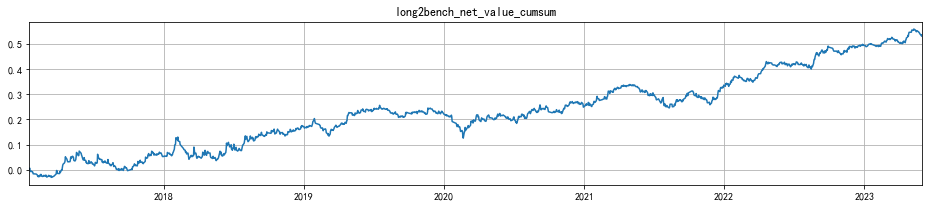

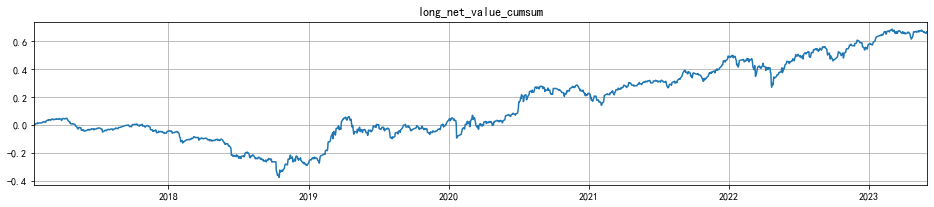

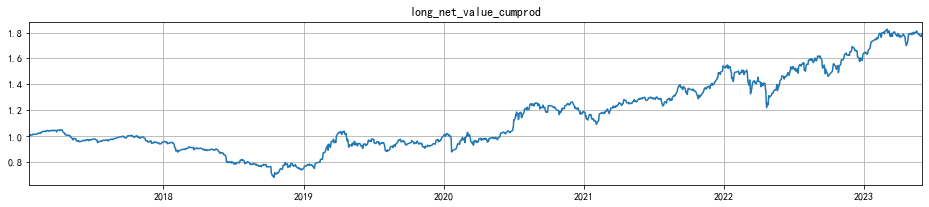

In [84]:
# 量稳换手率因子
C = SingleFactorAnalysis('000985.SH', '20170116', '20230601', 'factor_str', 'pct_close_next_close', long_low=1, dt_index='240m', n_group=10, neu_style=None, calc_crowd=False)
result_df = C.run_code(nextpct_shift=1)
result_df

factor_name: factor_utr
start_date,end_date 2017-01-16 2023-06-01


100%|██████████████████████████████████████████████████████████████████████████████| 1549/1549 [00:29<00:00, 52.20it/s]


Sharpe ratio of long_ret_cumprod is:  0.695
Sharpe ratio of long2bench is:  nan
Max drawdown of long_ret_cumprod is: -34.99%


,turnover,gross,net
group_01,0.143150,0.000592,0.000391
group_02,0.276896,0.000458,0.000070
group_03,0.297951,0.000405,-0.000013
group_04,0.315669,0.000276,-0.000166
group_05,0.252696,0.000209,-0.000145
group_06,0.234412,0.000062,-0.000266
group_07,0.189099,0.000012,-0.000253
group_08,0.155504,-0.000098,-0.000316
group_09,0.125602,-0.000421,-0.000597
group_10,0.082986,-0.001494,-0.001611


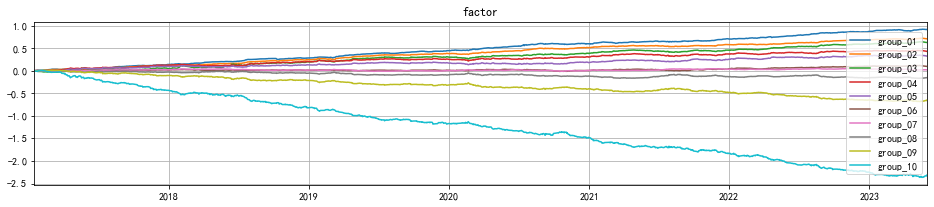

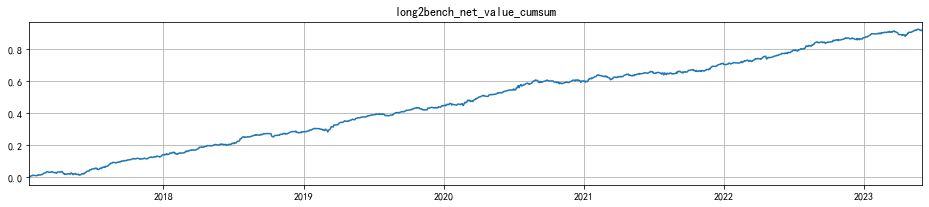

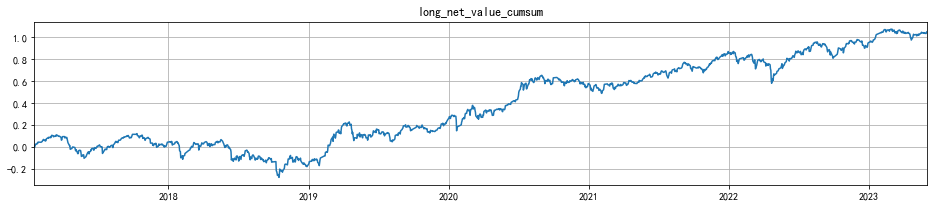

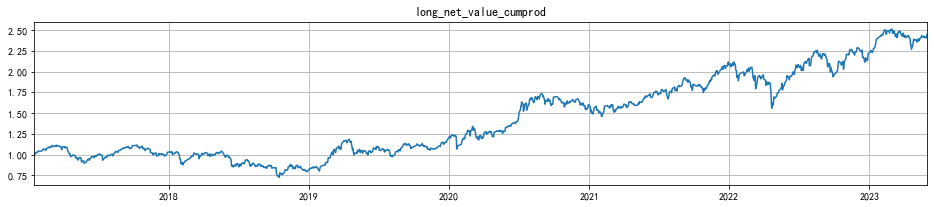

In [120]:
# 优加换手率因子UTR
C = SingleFactorAnalysis('000985.SH', '20170116', '20230601', 'factor_utr', 'pct_close_next_close', long_low=1, dt_index='240m', n_group=10, neu_style=None, calc_crowd=False)
result_df = C.run_code(nextpct_shift=1)
result_df

factor_name: factor_utr2
start_date,end_date 2017-01-16 2023-06-01


100%|██████████████████████████████████████████████████████████████████████████████| 1549/1549 [00:28<00:00, 54.36it/s]


Sharpe ratio of long_ret_cumprod is:  0.581
Sharpe ratio of long2bench is:  1.029
Max drawdown of long_ret_cumprod is: -35.32%


,turnover,gross,net
group_01,0.133083,0.000562,0.000376
group_02,0.242722,0.000426,0.000086
group_03,0.272283,0.000352,-0.000029
group_04,0.272044,0.000347,-0.000033
group_05,0.250959,0.000235,-0.000117
group_06,0.218099,0.000177,-0.000129
group_07,0.185878,0.000046,-0.000215
group_08,0.176329,-0.000107,-0.000353
group_09,0.132829,-0.000545,-0.000731
group_10,0.083310,-0.001492,-0.001609


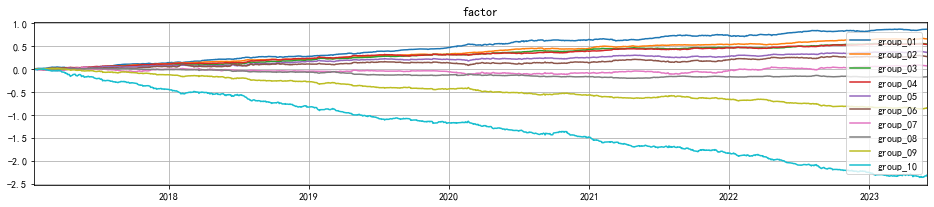

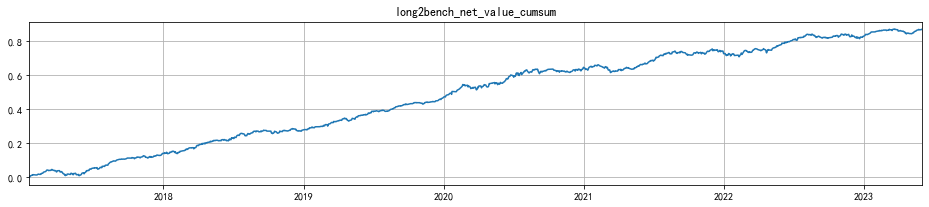

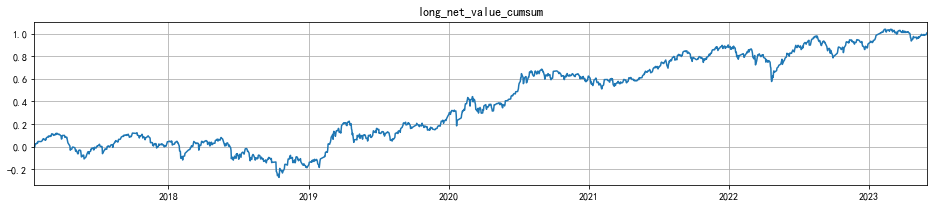

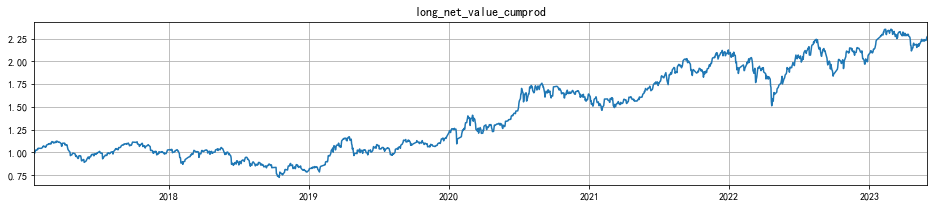

In [124]:
# 优加换手率因子UTR2.0
C = SingleFactorAnalysis('000985.SH', '20170116', '20230601', 'factor_utr2', 'pct_close_next_close', long_low=1, dt_index='240m', n_group=10, neu_style=None, calc_crowd=False)
result_df = C.run_code(nextpct_shift=1)
result_df